# Tilt Correction

In astronomical spectroscopy, tilt correction is a calibration step that addresses optical
distortions and misalignments in spectroscopic instruments. These distortions cause wavelength
not be constant along the cross-dispersion (spatial) axis: spectral features appear tilted or
curved across the detector instead of being perfectly aligned with detector columns.

Tilt correction is carried out using a two-dimensional tilt function that describes how wavelength
positions shift across the spatial axis. The tilt function can be estimated from arc lamp
spectra, by measuring how the calibration line centroids vary along the cross-dispersion axis.

This tilt function can then be used to transform the two-dimensional spectroscopy images so that
wavelengths are aligned along straight lines parallel to the detector axes (known as 2D
rectification). This is particularly important for accurate wavelength calibration and robust sky
 subtraction.

In `specreduce`, the tilt function is represented as a 2D polynomial (an `astropy.modeling.models
.Polynomial2d` instance) of a given degree. The `specreduce.tilt_correction.TiltCorrection` class
 implements tilt correction by:

1. Identifying emission lines in an arc lamp spectrum (or multiple arc lamp spectra)
2. Fitting a 2D polynomial model to characterize the geometric distortion
3. Computing a transformation that maps the tilted features to straight lines
4. Applying this transformation to rectify the science frames

A single arc frame can often suffice, but the use of multiple arc lamps with different emission
line patterns helps constrain the transformation across the full wavelength range of the spectrograph.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.visualization import simple_norm
from specreduce.tilt_correction import TiltCorrection
from common import read_data

plt.rc('figure', figsize=(6.3, 2))
plt.rc('font', size=8)

## Read in the Arc Frames and Object Frame

This tutorial demonstrates 2D tilt correction (rectification) using three arc lamp
spectra observed with the [Gran Telescopio Canarias (GTC)](https://www.gtc.iac.es/)
[Osiris spectrograph](https://www.gtc.iac.es/instruments/osiris/). The arcs (HgAr, Ne, and Xe)
were observed with the OSIRIS R1000R grism configuration, which covers approximately 5100-10000 Å
at moderate resolution.

This example uses three arc lamp calibration frames and a single long-slit science frame, all observed with the OSIRIS instrument at the Gran Telescopio Canarias (GTC) in 2012. OSIRIS, which operated until 2023 before being upgraded to OSIRIS+, featured two 2048 x 4096 pixel Marconi CCD detectors. For simplicity and file size considerations, we use data from just one CCD that has been binned to 512 x 1024 pixels.

OSIRIS spectra exhibit significant tilt distortion that must be corrected to achieve reliable background subtraction. The example science frame comes from a time-series of spectroscopic observations taken during an exoplanet transit (transmission spectroscopy). The scientific importance of proper tilt correction is highlighted by the original analysis of this dataset - insufficient correction of the tilt distortion led to residual time variations in telluric absorption lines that compromised the scientific results.


In [ ]:
arcs, lamps, obj = read_data()
frames = arcs + [obj]
labels = lamps + ('Target',)

In [ ]:
fig, axs = plt.subplots(4, figsize=(6.3, 5), sharex='all', constrained_layout=True)
for i,d in enumerate(frames):
    axs[i].imshow(d.data, origin='lower', aspect='auto', cmap=plt.cm.Blues,
                  norm=simple_norm(d.data, stretch='log', vmin=0, vmax=250_000))
    axs[i].text(0.01, 0.9, labels[i], va='top', ha='left', c='k', transform=axs[i].transAxes)
plt.setp(axs, ylabel='CD axis [pix]')
plt.setp(axs[-1], xlabel='Dispersion axis [pix]');

## Initialize the Tilt Correction

The `TiltCorrection` class is initialized with the following parameters:

- Reference pixel: `(500, 300)` -
- Arc lamp data: List of `CCDData` objects containing arc lamp spectra  
- Cross-dispersion sampling:
  - Sample limits: `(50, 500)` - pixel range for sampling the cross-dispersion direction
  - Number of samples: `8` - number of points to sample along cross-dispersion

The initialization sets up the transformation model that will be used to map tilted spectral features to straight lines.

In [23]:
s = TiltCorrection((500, 300), arcs, cd_sample_lims=(50, 500), n_cd_samples=7)

## Find Arc Lines

After initializing the `TiltCorrection` object, the `find_arc_lines()` method detects emission peaks in the arc lamp spectra. This method takes a threshold parameter (in this case 5.0) to find significant emission lines above the background level.

The detected lines are used as reference points for mapping the spectral tilt and curvature across the detector. For each input arc lamp (HgAr, Ne, Xe), the method:

1. Analyzes spectra at multiple cross-dispersion positions
2. Identifies emission peaks above the threshold
3. Records the line positions to be used as fiducial points
4. Builds the dataset needed for fitting the geometric transformation

This step is crucial as the identified lines form the basis for calculating the correction that will straighten tilted spectral features.


In [24]:
s.find_arc_lines(2.5, noise_factor=10)

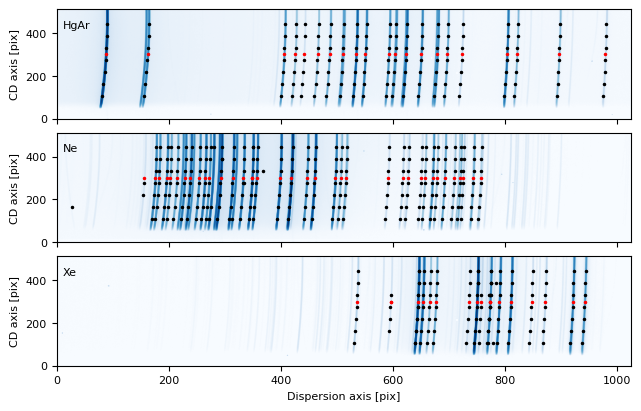

In [26]:
fig, axs = plt.subplots(3, figsize=(6.3, 4), sharex='all', constrained_layout=True)
for i,d in enumerate(arcs):
    axs[i].imshow(d.data, origin='lower', aspect='auto', cmap=plt.cm.Blues,
                  norm=simple_norm(d.data, stretch='log', vmin=0, vmax=250_000))
    axs[i].text(0.01, 0.9, lamps[i], va='top', ha='left', c='k', transform=axs[i].transAxes)
    axs[i].plot(s._samples_det_x[i], s._samples_det_y[i], 'k.', ms=3)
    axs[i].plot(s._lines_ref[i], np.full_like(s._lines_ref[i], s.ref_pixel[1]), 'r.', ms=3)
plt.setp(axs, ylabel='CD axis [pix]')
plt.setp(axs[-1], xlabel='Dispersion axis [pix]');

## Fit the model

The `fit()` method is used to calculate the geometric transformation that maps tilted spectral features to straight lines. This method:

1. Takes a `degree` parameter (set to 4 here) that determines the polynomial order of the transformation
2. Uses the arc line positions detected earlier as reference points
3. Performs an initial optimization to find a rough transformation
4. Refines the solution through further optimization
5. Generates the final transformation model that will be used to rectify the spectra

The fitted model captures both the tilt and any curvature present in the spectral features across the detector.

In [27]:
s.fit(degree=4)

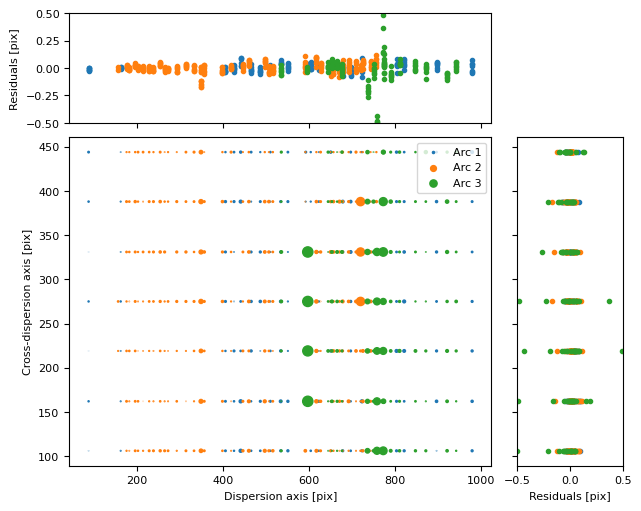

In [28]:
s.plot_fit_quality(figsize=(6.3, 5), rlim=(-0.5, 0.5))

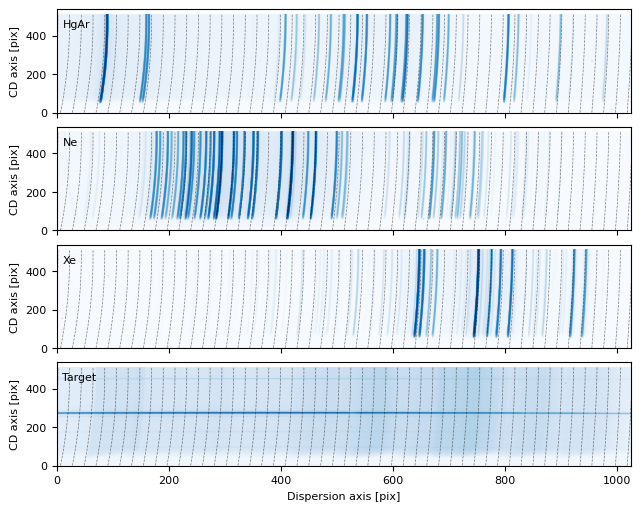

In [30]:
fig, axs = plt.subplots(4, figsize=(6.3, 5), sharex='all', constrained_layout=True)
for i,d in enumerate(frames):
    axs[i].imshow(d.data, origin='lower', aspect='auto', cmap=plt.cm.Blues,
                  norm=simple_norm(d.data, stretch='log', vmin=0, vmax=250_000))
    axs[i].text(0.01, 0.9, labels[i], va='top', ha='left', c='k', transform=axs[i].transAxes)
    s.plot_wavelength_contours(ax=axs[i])
plt.setp(axs, xlim=(0, arcs[0].shape[1]), ylabel='CD axis [pix]');
plt.setp(axs[-1], xlabel='Dispersion axis [pix]');

While there are some outliers present in the data, they don't appear to significantly impact the quality of the fit. If these outliers were causing issues with the fit accuracy, we could further refine the transformation model by calling `TiltCorrection.refine_fit()` with a restrictive `match_distance_bound` parameter (e.g., 0.5 pixels) to exclude these outlying points from the fit. This would ensure that only well-matched emission line positions are used to determine the transformation.


### Rectify the frames

After fitting the transformation model, we can apply it to rectify the spectral frames using the `TiltCorrection.rectify()` method. This method:

1. Takes the input frame data as a CCData object.
2. Applies the fitted geometric transformation to rebin the pixels using an exact flux-conserving
 approach.
3. Returns a new CCDData object where spectral features are aligned with detector rows/columns.

In this example, we apply the rectification both to the arc lamp calibration frames and the science target frame. The resulting rectified frames show spectral features that are properly aligned horizontally, making subsequent analysis steps like wavelength calibration and spectral extraction more straightforward and accurate.


In [31]:
rectified_data = [s.rectify(d.data) for d in frames]

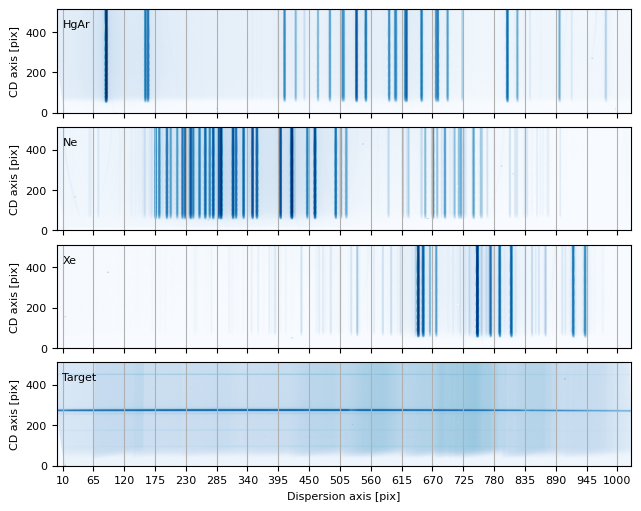

In [35]:
fig, axs = plt.subplots(4, figsize=(6.3, 5), sharex='all', constrained_layout=True)
for i,d in enumerate(rectified_data):
    axs[i].imshow(d.data, origin='lower', aspect='auto', cmap=plt.cm.Blues,
                  norm=simple_norm(d.data, stretch='log', vmin=0, vmax=150_000))
    axs[i].text(0.01, 0.9, labels[i], va='top', ha='left', c='k', transform=axs[i].transAxes)
    axs[i].grid(which='both', axis='x')
    axs[i].set_xticks(np.linspace(10, 1000, 19))
plt.setp(axs, ylabel='CD axis [pix]')
plt.setp(axs[-1], xlabel='Dispersion axis [pix]');

Let's still compare spectral features before and after rectification by examining emission lines.
The plot shows the reference row spectrum from the original (non-rectified) arc frame overlaid with spectra from different rows of the rectified frame. The alignment of spectral features across multiple rows in the rectified data demonstrates successful correction of the tilt, with emission line positions matching to sub-pixel precision as expected from a proper rectification.


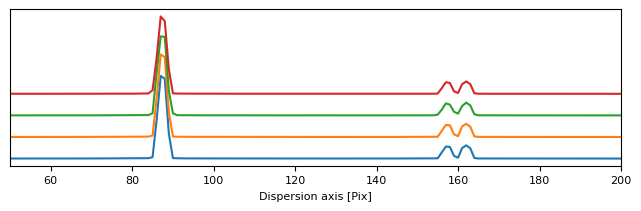

In [34]:
fig, ax = plt.subplots(1, figsize=(6.3, 2), sharex='all', constrained_layout=True)

ref_row = s.ref_pixel[1]
rec_rows = [s.ref_pixel[1], 150, 450]

ax.plot(arcs[0].data[ref_row])
for i, r in enumerate(rec_rows):
    ax.plot(50_000*(i+1) + rectified_data[0][r])
plt.setp(ax, xlabel='Dispersion axis [Pix]', yticks=[])
plt.setp(ax, xlim=(50, 200));